In this Notebook, the MOEA analysis is performed, as described in chapter 3.2 of the report.

### Imports

In [2]:
#   import packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import networkx as nx
import pickle
import functools

from ema_workbench import (
    Model,
    Policy,
    Scenario,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    util,
    ScalarOutcome,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
from ema_workbench.em_framework import parameters_from_csv
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import prim
from ema_workbench import Samplers

The model is loaded, and logging method is set.

In [6]:
# initiate model
dike_model, planning_steps = get_model_for_problem_formulation(5)
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

The results from the basecase open exploration, which includes the 20 worst scenarios, are loaded into a Pandas DataFrame.

In [7]:
# load open exploration results
open_exploration_results = pd.read_pickle(r'..\generated_datasets\open_exploration_base_policy_worst_scenarios.pkl')

These scenarios are then loaded into model scenarios.

In [8]:
# load scenarios into scenario instance of model.
scenarios = []
for row_number in range(open_exploration_results.shape[0]):
    scenarios.append(
        Scenario(name=row_number, **open_exploration_results.iloc[row_number, :16].to_dict())
    )

To calculate the robustness metrics, which are defined as the total annual damage, total expected number of deaths, total dike investment costs, total room for the river costs and total expected evacuation costs, lists of these variables are saved for later use.

|  Robustness metric 	   |    kind 	     | Points included	 |
|:----------------------:|:-------------:|:----------------:|
| Damage Cost          	 | Minimize    	 |     A.4, A.5     |
|     	Deaths Score      |       	Minimize       |   A.4, A.5   	   |
|   	 Dike Invest Cost   |       	Minimize       |     A.4, A.5     |
|    RfR Invest Cost     |       	Minimize       |      All 	       |
|    	Evacuation Cost    |       	Minimize       |      All 	       |


In [9]:
# List the names of vars to make `robustness_functions` a bit more read-able
damage_overijssel = ['A.4_Expected Annual Damage', 'A.5_Expected Annual Damage',]
deaths_overijssel = ['A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths',]
dike_investments_overijssel = ['A.4_Dike Investment Costs', 'A.5_Dike Investment Costs',]
var_list_rfr = ['RfR Total Costs',]
var_list_evac = ['Expected Evacuation Costs',]

Then, the robustness metric is initiated into a function. For this, we chose the Mean Square Deviation: $ MSD = \sigma ^{2} + \mu ^{2} $.

In [10]:
# Mean square deviation
def robust_sum(*data):
    """
    Function that takes in a column of data and returns the mean square deviation.

    Parameters
    ----------
    data: array of values

    Returns
    --------
    result: mean square difference of the input

    """

    sumsumsum = sum(sum(sum(data)))

    mean = np.mean(sumsumsum)
    iqr = sp.stats.iqr(sumsumsum)
    result = np.square(mean) + np.square(iqr)

    return result

Then, we make the robustness functions and add constraints. We chose to minimize the functions, as this method is the most conservative (Kwakkel, J. H., Eker, S., & Pruyt, E. (2016). How robust is a robust policy? Comparing alternative robustness metrics for robust decision-making. Robustness analysis in decision aiding, optimization, and analytics, 221-237.)

In [11]:
# robustness metrics
minimize = ScalarOutcome.MINIMIZE

robustness_functions = [
    ScalarOutcome('Damage Cost',
                  variable_name=damage_overijssel,
                  function=robust_sum,
                  kind=minimize,
                  ),
    ScalarOutcome('Deaths Score',
                  variable_name=deaths_overijssel,
                  function=robust_sum,
                  kind=minimize,
                  ),
    ScalarOutcome('Dike Invest Cost',
                  variable_name=dike_investments_overijssel,
                  function=robust_sum,
                  kind=minimize,
                  ),
    ScalarOutcome("RfR Invest Cost",
                  kind=minimize,
                  function=robust_sum,
                  variable_name="RfR Total Costs"),
    ScalarOutcome("Evacuation Cost",
                  kind=minimize,
                  function=robust_sum,
                  variable_name="Expected Evacuation Costs"),
]

Convergence metrics are loaded, which is used to track $\epsilon$-progress

In [12]:
# define convergvence metrics for model run
convergence_metrics = [
    ArchiveLogger(
        "../archives",
        [l.name for l in dike_model.levers],
        [o.name for o in robustness_functions],
        base_filename="robust_optimization_test.tar.gz",
    ),
    EpsilonProgress(),
]

Finally, the model variables are set. 30 000 function evaluations, as this was tested to be enough for the $\epsilon$ to roughly stabilize. Epsilon values of 0.01, as this resulted in the desired outcome of policies.

In [13]:
# general input
nfe = int(30000)
epsilons = [0.01, ]*len(robustness_functions)


Then, the model can be run. Results (pareto set of policies) are saved. A population size of 5 was chosen.

# Model run

In [18]:
# Run MOEA
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustness_functions,
                                                     scenarios=scenarios,
                                                     nfe=nfe,
                                                     epsilons=epsilons,
                                                     convergence=convergence_metrics,
                                                     population_size=5,
                                                     )

with open(r'../generated_datasets/initial_Pareto_policies.pkl', 'wb') as file_pi:
    pickle.dump(results, file_pi)

with open(r'../generated_datasets/initial_Pareto_policies_convergence.pkl', 'wb') as file_pi:
    pickle.dump(convergence, file_pi)

[MainProcess/INFO] pool started with 12 workers
 14%|████▍                           | 4129/30000 [2:25:02<15:02:24,  2.09s/it]C:\Users\beren\AppData\Local\Temp\ipykernel_9644\177012953.py:3: RuntimeWarning: overflow encountered in long_scalars
  sumsumsum = sum(sum(sum(data)))
30495it [18:03:37,  2.13s/it]                                                  
[MainProcess/INFO] optimization completed, found 45 solutions
[MainProcess/INFO] terminating pool


# Visualizations

$\epsilon$-convergence graph, showing whether the $\epsilon$ was converged.

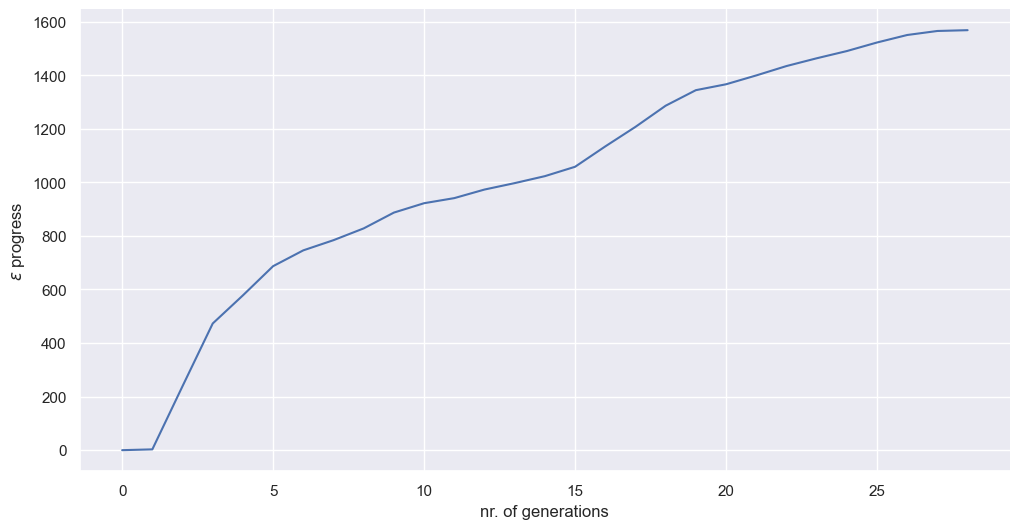

In [14]:
# convergence data is loaded into a variable
convergence = pd.read_pickle(r'../generated_datasets/initial_Pareto_policies_convergence.pkl')

# convergence plot is made
plt.plot(convergence.epsilon_progress)
plt.xlabel("Number of function evaluations")
plt.ylabel(r"$\epsilon$ progress")
sns.despine()
plt.savefig(r'../Visualizations/MOEA/epsilon_progress_robust_optimize.png', bbox_inches='tight')
plt.show()
sns.set(rc={'figure.figsize':(12,6)})


Robustness score graph, to show the outcome of the robustness scores of the policies.

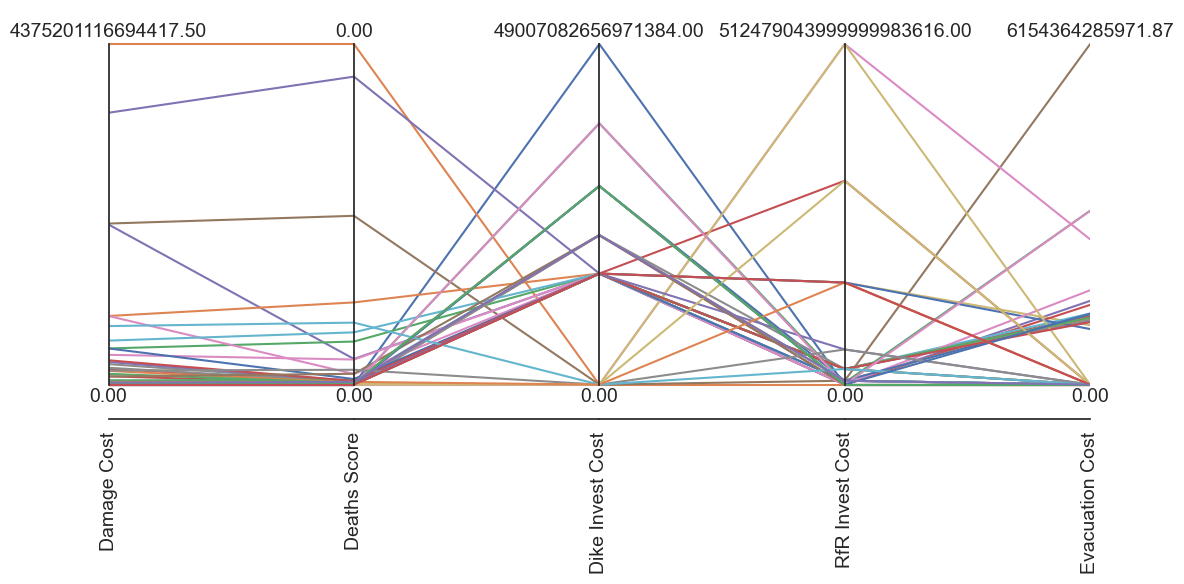

In [15]:
# Pareto policies loaded into variable
df = pd.read_pickle(r'../generated_datasets/initial_Pareto_policies.pkl')

# plotting of policies
data = df.loc[:, [o.name for o in robustness_functions]]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
sns.despine()
plt.savefig(r'../visualizations/MOEA/pareto_visualization.png', bbox_inches='tight')
sns.set(rc={'figure.figsize': (15, 6)})

shows the relative tradeoffs. as damage costs and death costs increase, dike investments and investment costs tend to act acccordingly.